# FBI map and ratios

A study of the response of FBI and FBI+Ba2+ to different excitation light

In [280]:
using CSV
using DataFrames
using PlutoUI
using Shapefile
using ZipFile
using LsqFit
using Plots
using Statistics
using Dates
using Interpolations
using QuadGK

In [2]:
using DrWatson

In [111]:
import Pkg; 
Pkg.add("StatsPlots")
using StatsPlots

  Resolving package versions...
  Installed Arpack_jll ──────── v3.5.0+3
  Installed TableOperations ─── v1.0.0
  Installed StatsPlots ──────── v0.14.19
  Installed Arpack ──────────── v0.4.0
  Installed MultivariateStats ─ v0.8.0
  Installed DataValues ──────── v0.4.13
  Installed NearestNeighbors ── v0.4.8
  Installed OpenBLAS_jll ────── v0.3.9+5
test/data/hclust_generated_examples.jl.gz: truncated gzip input
tar: Error exit delayed from previous errors.
┌ Warning: failed to extract archive downloaded from https://pkg.julialang.org/package/aaaa29a8-35af-508c-8bc3-b662a17a0fe5/75479b7df4167267d75294d14b58244695beb2ac
└ @ Pkg.Operations /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Operations.jl:559
  Installed Clustering ──────── v0.14.2
Updating `~/JuliaProjects/LabFBI/Project.toml`
  [f3b207a7] + StatsPlots v0.14.19
Updating `~/JuliaProjects/LabFBI/Manifest.toml`
  [621f4979] + AbstractFFTs v1.0.1
  [7d9fca2a] + Arpack v0.4.0
  [68821587] + A

## Globals

In [3]:
datadir()

"/Users/jj/JuliaProjects/LabFBI/data"

In [4]:
begin
    markershapes = [:circle]
    markercolors = [:green :orange :black :purple :red  :yellow :brown :white]
end

1×8 Array{Symbol,2}:
 :green  :orange  :black  :purple  :red  :yellow  :brown  :white

In [320]:
begin
    mapv = ["E250", "E275", "E300", "E325", "E350","E375","E400"];
    mapx = [:purple :blue   :green  :yellow :orange :brown :red ];
    maps = [:E250 :E275 :E300 :E325 :E350 :E375 :E400];
end

1×7 Array{Symbol,2}:
 :E250  :E275  :E300  :E325  :E350  :E375  :E400

In [334]:
mapl = [parse(Float64, elm[2:end]) for elm in mapv ]

7-element Array{Float64,1}:
 250.0
 275.0
 300.0
 325.0
 350.0
 375.0
 400.0

## Functions

In [5]:
function read_csv(filename::String)
    csv_data = CSV.File(filename)   
    data = DataFrame(csv_data)
    return data
end

read_csv (generic function with 1 method)

In [54]:
"""
In a DataFrame one has often "XY" variables, that is, a pair of columns "X" and "Y" 
which represent correlated variables (e.g, intensity and wavelength). 
In such cases one often wants the XY maximum, that is, finding the maximum of "Y" 
(call it ymax) and the corresponding value in "X" (x for which y is ymax). 
This corresponds, for example, to the wavelength at which the intensity is maximal. 
"""
function find_max_xy(df::DataFrame, xc::String, yc::String)
    #find ymax
    ymax, imax = findmax(df[!, yc]) # function findmax returns value and index of max
    x_ymax = df[imax, xc]
    return ymax, x_ymax
end

find_max_xy

In [300]:
"""
Function maxI returns the Intensity corresponding to the maximum λ for a given df and
a set of vars
"""
maxI(df, mapvars) = [find_max_xy(df, "λ", var)[1] for var in mapvars]

maxI

In [303]:
"""
Compute the ratio of intensities between FBI and FBI-BA
"""
function intensity_ratio(fbidf, fbibadf, mapv)
    ifbi    = maxI(fbidf, mapv)
    ifbiba  = maxI(fbibadf, mapv)
    return ifbiba ./ ifbi
end

intensity_ratio

In [302]:
"""
plots variables mapvars from df. See below for a simpler solution based on @df macro
"""
function plot_map(df, title, mapvars, maplbls, mapcolors, legend=:topright)
    plt = plot(df.λ, df[:,mapvars[1]],
        label = maplbls[1],
        #shape = :circle,
        color = mapcolors[1],
        #markersize = 1, 
        leg=legend)
    for (i, var) in enumerate(mapvars[2:end])
        plt = plot!(plt, df.λ, df[:,var],
            label = maplbls[i+1],
            color = mapcolors[i+1],
            leg=legend)
    end
    display(plt)
    xlabel!("λ (nm)")
    ylabel!("Intensity(AU)")
    title!(title)
end

plot_map

In [304]:
"""
Combine variables vars from the dataframes in DFL
"""
function combine_df_plots(DFL, 
                          vars=["E275","E325","E375","E400"], 
                          legend=:topright)
    P = []
    for var in vars
        lbl = string(var,"-r1")
        println("var = $var lbl = $lbl")
        df = DFL[1]
        pdf =  @df df plot(:λ, df[:,var], label= lbl, colour = markercolors[1], legend=legend)
        for (i, df)  in enumerate(DFL[2:end])
            lbl = string(var,"-r$(i+1)")
            println("var = $var lbl = $lbl")
            pdf =  @df df plot!(pdf, :λ, df[:,var], label= lbl, colour = markercolors[i+1], legend=legend)
        end
        xlabel!("λ (nm)")
        ylabel!("Intensity(AU)")
        title!(var)
        push!(P,pdf)      
    end
    return P
end

combine_df_plots

## Data

In [253]:
begin
    mapFbiBa =["EDI044_Silice_FBI_Ba_march2021_map.csv", 
               "EDI044_Silice_FBI_Ba_march2021_map_3.csv",
               "EDI044_Silice_FBI_Ba_march2021_map_4.csv"]
    
    mapFbi = ["EDI044_Silice_FBI_march2021_map.csv",
              "EDI044_Silice_FBI_march2021_map_3.csv",
              "EDI044_Silice_FBI_march2021_map_4.csv"]
    
    selFbiBa =["EDI044_FBI_Ba_round4_em325_375_405.csv",
             "EDI044_FBI_Ba_round5_em325_375_405.csv"]

    selFbi =["EDI044_FBI_round4_em325_375_405.csv",
               "EDI044_FBI_round5_em325_375_405.csv"]

    path=string(datadir(),"/fluorimeter")
    
    mfbi =   [string(path,"/", fbi) for fbi in mapFbi]
    mfbiba = [string(path,"/", fbi) for fbi in mapFbiBa]
    sfbi =   [string(path,"/", fbi) for fbi in selFbi]
    sfbiba = [string(path,"/", fbi) for fbi in selFbiBa]
    
    fbiabs = string(path,"/", "EDI_029_absorption.csv")
end

"/Users/jj/JuliaProjects/LabFBI/data/fluorimeter/EDI_029_absorption.csv"

In [261]:

csvMapFbi = [CSV.File(fbi; delim=';', decimal=',') for fbi in mfbi]    
mfbidf = [DataFrame(csv) for csv in csvMapFbi]
csvMapFbiBa = [CSV.File(fbi; delim=';', decimal=',') for fbi in mfbiba]    
mfbibadf = [DataFrame(csv) for csv in csvMapFbiBa]
mfbibadf[1] = mfbibadf[1][:,2:end];


In [352]:
csv_fbiabs = CSV.File(fbiabs; delim=';', decimal=',');    
fbiabsdf = DataFrame(csv_fbiabs);

In [364]:
csvSelFbi = CSV.File(sfbi[1]; delim=';', decimal=',')
fbidf = DataFrame(csvSelFbi);

In [365]:
csvSelFbiBa = CSV.File(sfbiba[1]; delim=';', decimal=',')
fbibadf = DataFrame(csvSelFbiBa);

### Absorption (in solution) for FBI and FBI-BA

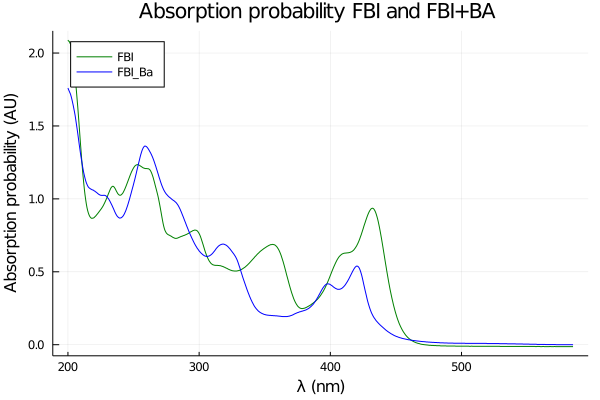

In [283]:
@df fbiabsdf plot(:λ, [:FBI :FBI_Ba], 
               colour = [:green :blue],
               legend=:topleft)
xlabel!("λ (nm)")
ylabel!("Absorption probability (AU)")
title!("Absorption probability FBI and FBI+BA ")

#### FBI-BA /FBI for the absorption

In [139]:
rFbiBaFbi = fbiabsdf.FBI_Ba  ./ fbiabsdf.FBI;

In [127]:
begin
    wf = 200. 
    we = 585.
    ws = 0.5
    wl = wf:ws:we
end

200.0:0.5:585.0

In [335]:
rba2fbi = LinearInterpolation(wl, rFbiBaFbi);

In [336]:
r2abs = rba2fbi.(mapl)

7-element Array{Float64,1}:
 0.9075907590759077
 1.3485639686684072
 0.8438320209973753
 1.2578740157480315
 0.3122171945701357
 0.8270676691729323
 0.8673684210526316

## Maps

Maps of the response of FBI in silica powder have been computed scanning a range of frequencies between 205 and 405 for FBI and FBI-BA. Maps have been repeated in different days to study the effect on the response of the evaporation of solvent with time. 

In [269]:
begin
    mapv = ["E250", "E275", "E300", "E325", "E350","E375","E400"];
    mapx = [:purple :blue   :green  :yellow :orange :brown :red ];
    maps = [:E250 :E275 :E300 :E325 :E350 :E375 :E400];
end

1×7 Array{Symbol,2}:
 :E250  :E275  :E300  :E325  :E350  :E375  :E400

In [288]:
#plot_map(mfbidf[1],"Map, FBI round 1", mapv, mapv, mapx,:topleft)

A simpler way to plot

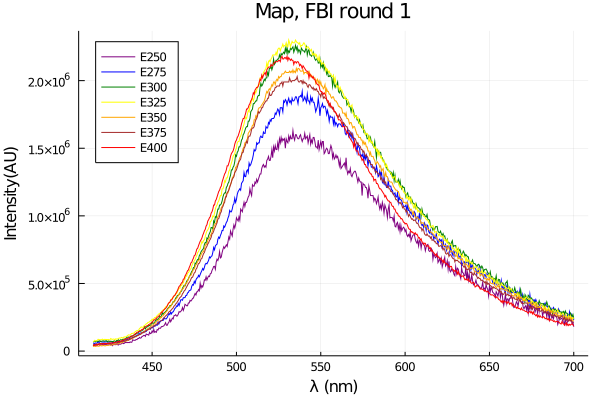

In [423]:
@df mfbidf[1] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topleft, fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI round 1")


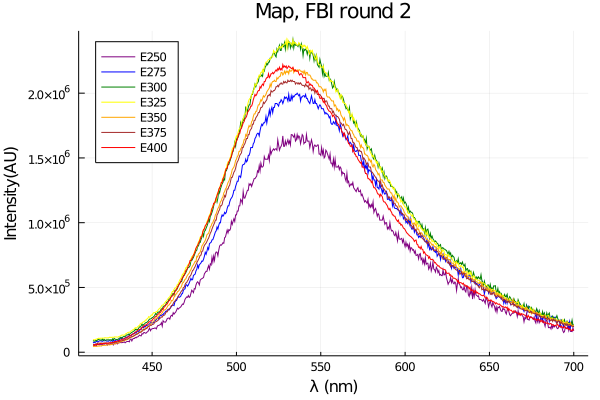

In [426]:
@df mfbidf[2] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topleft,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI round 2")


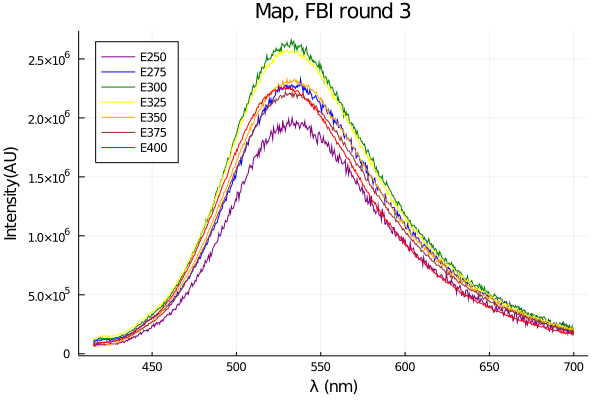

In [424]:
@df mfbidf[3] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topleft,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI round 3")


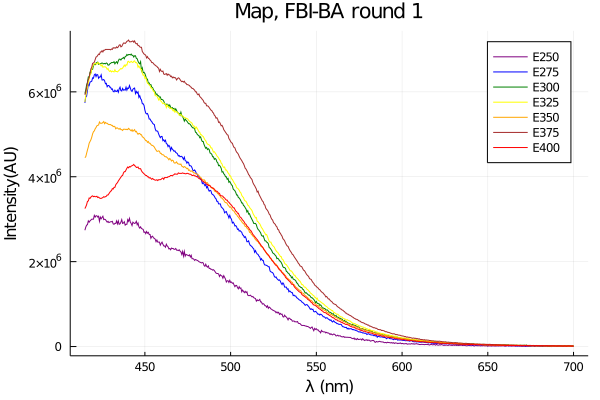

In [425]:
@df mfbibadf[1] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI-BA round 1")

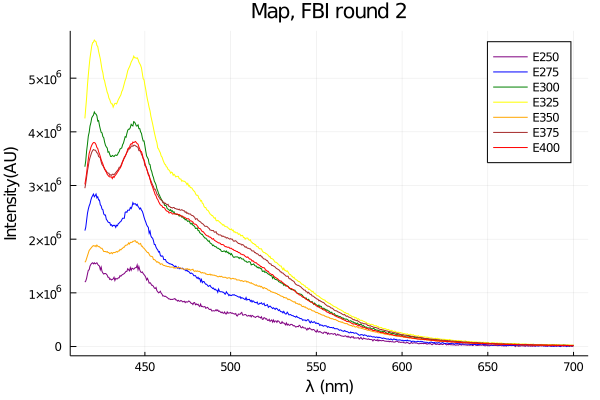

In [427]:
@df mfbibadf[2] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI round 2")

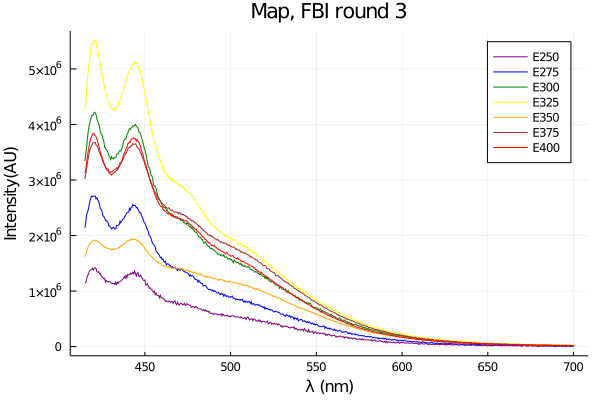

In [428]:
@df mfbibadf[3] plot(:λ, [:E250 :E275 :E300 :E325 :E350 :E375 :E400], 
               colour = [:purple :blue   :green  :yellow :orange :brown :red ],
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("Map, FBI round 3")


In [295]:
cfbip = combine_df_plots(mfbidf)

var = E275 lbl = E275-r1
var = E275 lbl = E275-r2
var = E275 lbl = E275-r3
var = E325 lbl = E325-r1
var = E325 lbl = E325-r2
var = E325 lbl = E325-r3
var = E375 lbl = E375-r1
var = E375 lbl = E375-r2
var = E375 lbl = E375-r3
var = E400 lbl = E400-r1
var = E400 lbl = E400-r2
var = E400 lbl = E400-r3


4-element Array{Any,1}:
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}

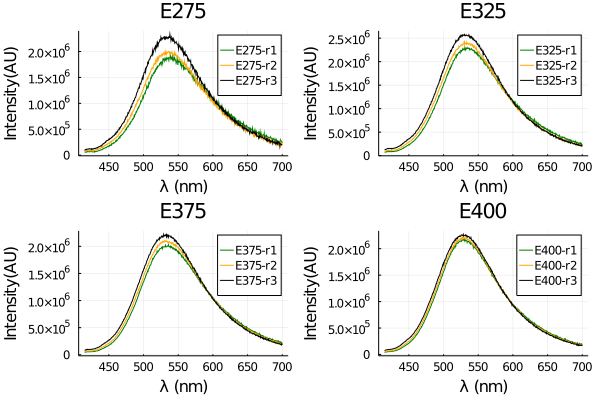

In [429]:
plot(cfbip[1], cfbip[2], cfbip[3], cfbip[4], layout = (2, 2), legend = :topright, fmt = :png)

In [297]:
cfbibap = combine_df_plots(mfbibadf)

var = E275 lbl = E275-r1
var = E275 lbl = E275-r2
var = E275 lbl = E275-r3
var = E325 lbl = E325-r1
var = E325 lbl = E325-r2
var = E325 lbl = E325-r3
var = E375 lbl = E375-r1
var = E375 lbl = E375-r2
var = E375 lbl = E375-r3
var = E400 lbl = E400-r1
var = E400 lbl = E400-r2
var = E400 lbl = E400-r3


4-element Array{Any,1}:
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}

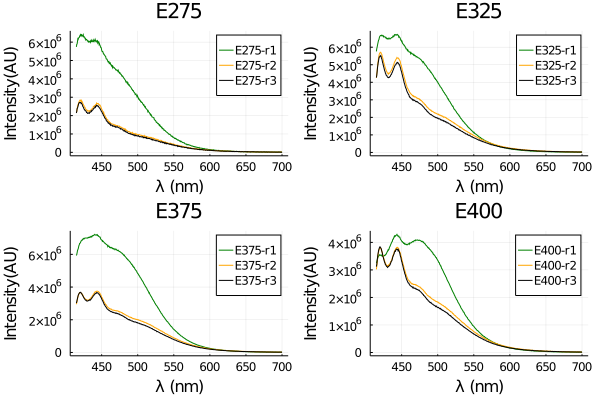

In [430]:
plot(cfbibap[1], cfbibap[2], cfbibap[3], cfbibap[4], layout = (2, 2), legend = :topright, fmt = :png)

## Intensity ratios

In [435]:
mi   = [maxI(fbidf, mapv) for fbidf in mfbidf];
miba = [maxI(fbidf, mapv) for fbidf in mfbibadf]

3-element Array{Array{Float64,1},1}:
 [3.09e6, 6.42e6, 6.89e6, 6.73e6, 5.3e6, 7.22e6, 4.29e6]
 [1.56e6, 2.84e6, 4.37e6, 5.71e6, 1.97e6, 3.75e6, 3.82e6]
 [1.42e6, 2.71e6, 4.22e6, 5.52e6, 1.94e6, 3.68e6, 3.84e6]

In [436]:
r2 = [intensity_ratio(mfbidf[i], mfbibadf[i], mapv) for i in 1:3 ]

3-element Array{Array{Float64,1},1}:
 [1.8957055214723926, 3.34375, 3.0486725663716814, 2.9260869565217393, 2.535885167464115, 3.5566502463054186, 1.9678899082568808]
 [0.9285714285714286, 1.42, 1.8132780082987552, 2.3692946058091287, 0.8995433789954338, 1.7857142857142858, 1.7207207207207207]
 [0.71, 1.1630901287553648, 1.586466165413534, 2.13953488372093, 0.8326180257510729, 1.6576576576576576, 1.6916299559471366]

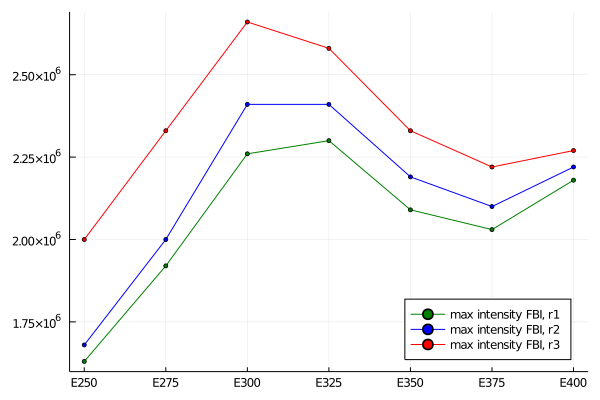

In [438]:
p1 = plot(mapv, mi[1],
        label = "max intensity FBI, r1",
        shape = :circle,
        color = :green,
        markersize = 3, 
        leg=:bottomright,fmt = :png)

p1 = plot!(p1, mapv, mi[2],
        label = "max intensity FBI, r2",
        shape = :circle,
        color = :blue,
        markersize = 3, 
        leg=:bottomright,fmt = :png)

p1 = plot!(p1, mapv, mi[3],
        label = "max intensity FBI, r3",
        shape = :circle,
        color = :red,
        markersize = 3, 
        leg=:bottomright,fmt = :png)





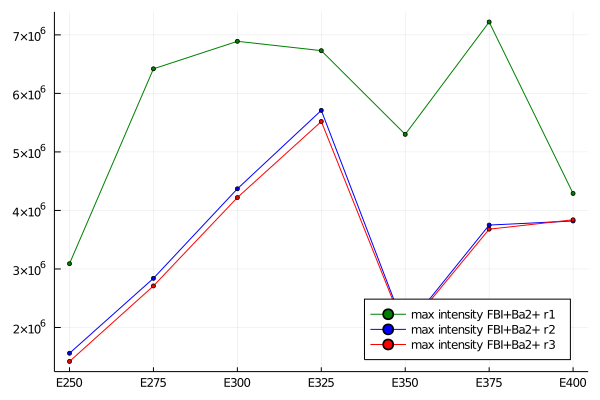

In [433]:
p2 = plot(mapv, miba[1],
        label = "max intensity FBI+Ba2+ r1 ",
        shape = :circle,
        color = :green,
        markersize = 3, 
        leg=:bottomright,fmt = :png)

p2 = plot!(p2, mapv, miba[2],
        label = "max intensity FBI+Ba2+ r2",
        shape = :circle,
        color = :blue,
        markersize = 3, 
        leg=:bottomright,fmt = :png)

p2 = plot!(p2, mapv, miba[3],
        label = "max intensity FBI+Ba2+ r3",
        shape = :circle,
        color = :red,
        markersize = 3, 
        leg=:bottomright,fmt = :png)

#ylims!((10^6, 10^7))




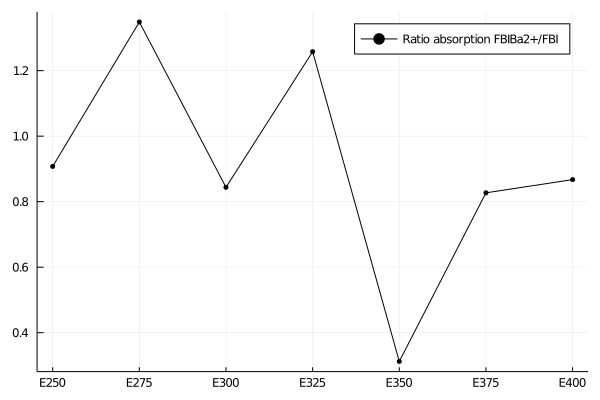

In [345]:
p3 = plot(mapv, r2abs,
        label = "Ratio absorption FBIBa2+/FBI",
        shape = :circle,
        color = :black,
        markersize = 3, 
        leg=:topright)



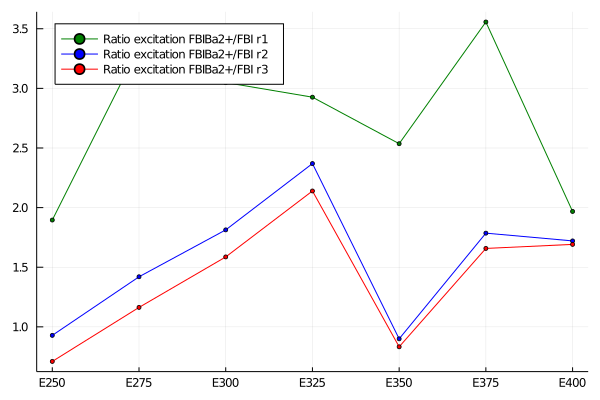

In [439]:
p4 = plot(mapv, r2[1],
        label = "Ratio excitation FBIBa2+/FBI r1",
        shape = :circle,
        color = :green,
        markersize = 3, 
        leg=:topleft,fmt = :png)

p4 = plot!(p4, mapv, r2[2],
        label = "Ratio excitation FBIBa2+/FBI r2 ",
        shape = :circle,
        color = :blue,
        markersize = 3, 
        leg=:topleft,fmt = :png)

p4 = plot!(p4, mapv, r2[3],
        label = "Ratio excitation FBIBa2+/FBI r3",
        shape = :circle,
        color = :red,
        markersize = 3, 
        leg=:topleft,fmt = :png)



## Selected

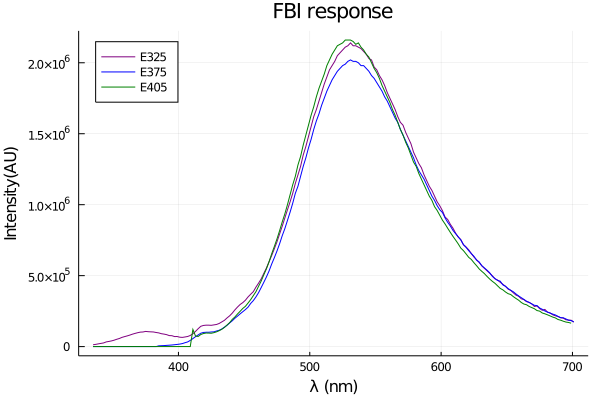

In [440]:
@df fbidf plot(:λ, [:E325 :E375 :E405], 
               colour = [:purple :blue   :green ],
               legend=:topleft,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI response")

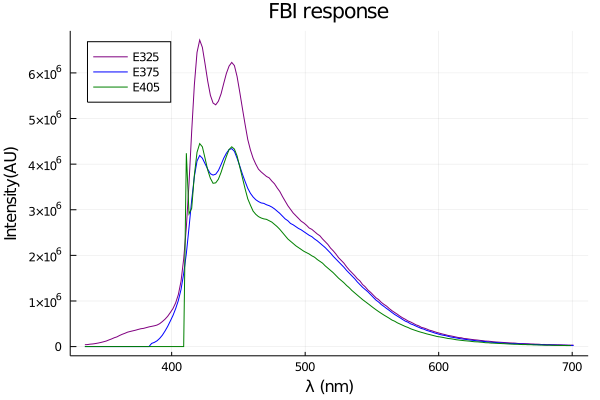

In [441]:
@df fbibadf plot(:λ, [:E325 :E375 :E405], 
               colour = [:purple :blue   :green ],
               legend=:topleft,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI response")

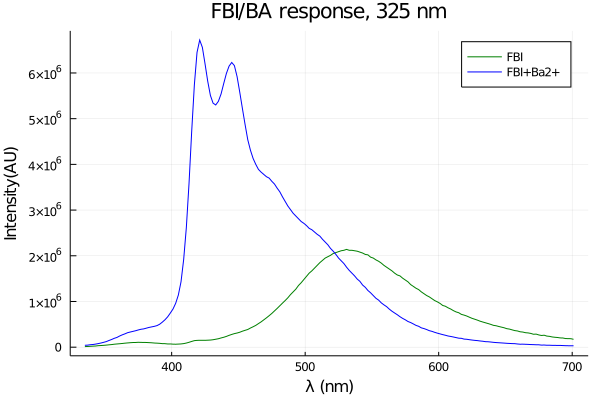

In [442]:
@df fbidf plot(:λ, :E325, 
               colour = :green,
               label  ="FBI",
               legend=:topright)
@df fbibadf plot!(:λ, :E325, 
               colour = :blue,
               label  ="FBI+Ba2+",
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI/BA response, 325 nm")

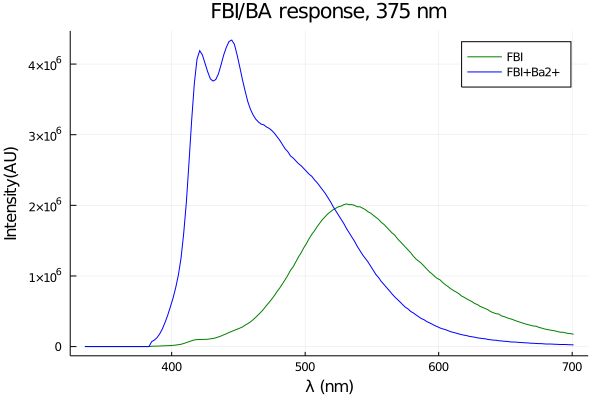

In [443]:
@df fbidf plot(:λ, :E375, 
               colour = :green,
               label  ="FBI",
               legend=:topright)
@df fbibadf plot!(:λ, :E375, 
               colour = :blue,
               label  ="FBI+Ba2+",
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI/BA response, 375 nm")

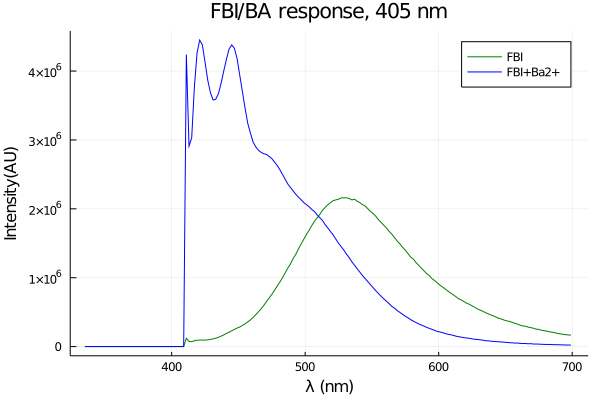

In [444]:
@df fbidf plot(:λ, :E405, 
               colour = :green,
               label  ="FBI",
               legend=:topright)
@df fbibadf plot!(:λ, :E405, 
               colour = :blue,
               label  ="FBI+Ba2+",
               legend=:topright,fmt = :png)
xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI/BA response, 405 nm")

In [378]:
begin
    wf = 335. 
    we = 701.
    ws = 2.
    wl = wf:ws:we
end

335.0:2.0:701.0

In [380]:
fbi375 = LinearInterpolation(wl, fbidf[!,"E375"]);
fbiba375 = LinearInterpolation(wl, fbibadf[!,"E375"]);

In [382]:
L =collect(wl)
FBI = fbi375.(L)
FBIBA = fbiba375.(L);

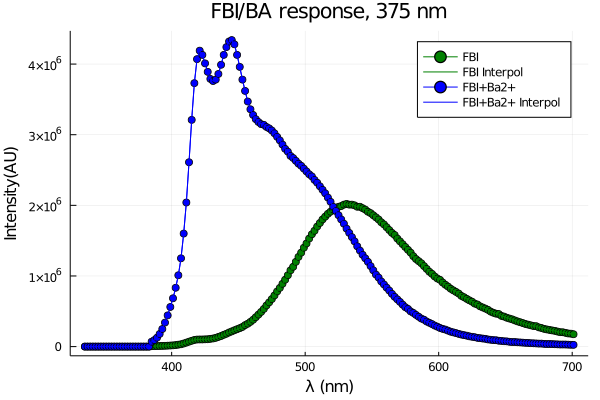

In [383]:
@df fbidf plot(:λ, :E375, 
               colour = :green,
               shape = :circle,
               label  ="FBI",
               legend=:topright)
plot!(L, FBI,
    colour = :green,           
    label  ="FBI Interpol",
    legend=:topright)

@df fbibadf plot!(:λ, :E375, 
               colour = :blue,
               shape = :circle,
               label  ="FBI+Ba2+",
               legend=:topright)

plot!(L, FBIBA,
    colour = :blue,           
    label  ="FBI+Ba2+ Interpol",
    legend=:topright)


xlabel!("λ (nm)")
ylabel!("Intensity(AU)")
title!("FBI/BA response, 375 nm")

In [419]:
function rfbi(λ::Float64, f, wf = 335.0, we = 701.0)
    i1, eps = quadgk(f, wf, λ) 
    it, eps =quadgk(f, wf, we)
    return i1 / it
end
function interval_rfbi(λ1::Float64, λ2::Float64, f, wf = 335.0, we = 701.0)
    i1, eps = quadgk(f, λ1, λ2) 
    it, eps =quadgk(f, wf, we)
    return i1 / it
end
function r2fbi(λ::Float64, fbiba, fbi, wf = 335.0, we = 701.0)
    return rfbi(λ, fbiba, wf, we) / rfbi(λ, fbi, wf, we)
end
function interval_r2fbi(λ1::Float64, λ2::Float64, fbiba, fbi, wf = 335.0, we = 701.0)
    return interval_rfbi(λ1, λ2, fbiba, wf, we) / interval_rfbi(λ1, λ2, fbi, wf, we)
end

interval_r2fbi (generic function with 3 methods)

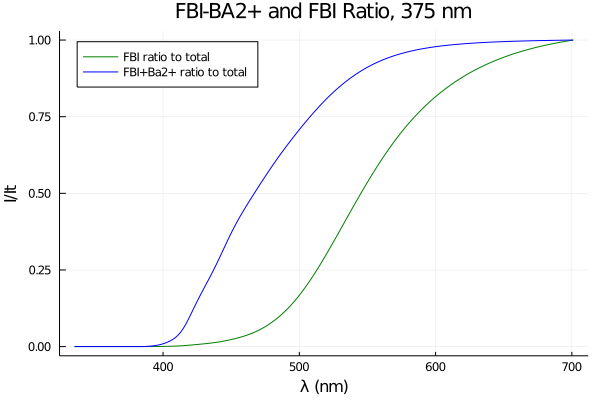

In [445]:
plot(L, rfbi.(L, (fbi375,),),
    colour = :green,           
    label  ="FBI ratio to total",
    legend=:topleft,fmt = :png)

plot!(L, rfbi.(L, (fbiba375,),),
    colour = :blue,           
    label  ="FBI+Ba2+ ratio to total",
    legend=:topleft,fmt = :png)
xlabel!("λ (nm)")
ylabel!("I/It")
title!("FBI-BA2+ and FBI Ratio, 375 nm")

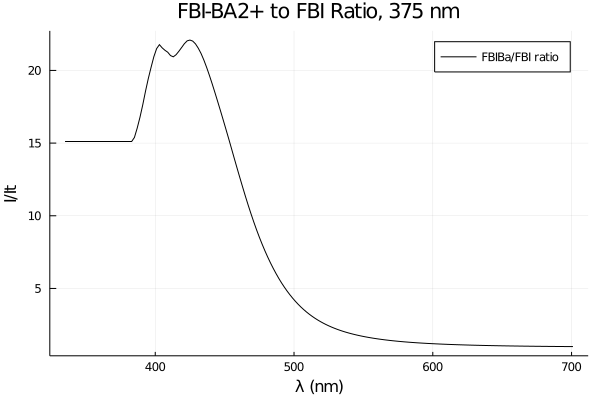

In [446]:
R2 = r2fbi.(L, (fbiba375,), (fbi375,), 400., 700.)
plot(L, R2,
    colour = :black,           
    label  ="FBIBa/FBI ratio",
    legend=:topright,fmt = :png)

xlabel!("λ (nm)")
ylabel!("I/It")
title!("FBI-BA2+ to FBI Ratio, 375 nm")

In [414]:
ymax, imax = findmax(R2)

(22.088559601310212, 46)

In [415]:
L[46]

425.0

In [420]:
r2  = interval_r2fbi(425.0, 435.0, fbiba375, fbi375)

18.66545005843158

In [421]:
rFBI  = interval_rfbi(425.0, 435.0, fbi375)

0.004530111146201259

In [422]:
rFbiBa  = interval_rfbi(425.0, 435.0, fbiba375)

0.08455656335856385